In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from scipy import signal
from scipy import fftpack  # Fourier
from scipy.ndimage import maximum_filter1d
from scipy import stats
from librosa.feature import mfcc, spectral_contrast, zero_crossing_rate
from tsfresh.feature_extraction import feature_calculators as fc
import pywt
from bokeh.plotting import figure, show
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA




/usr/lib/python3.10/site-packages/numba/np/ufunc/ufuncbuilder.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  self.nb_func = jit(_target='npyufunc', cache=cache)(py_func)


### Loading

In [3]:
train = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/train/train_data.csv')
test = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/test/test_data.csv')
train.head()

,Datetime,I06H1,I06H2,I06H3,I06H4,I06H6,I06H7,I06H8
0,2018-07-01 03:00:09.350,0.656045,0.368027,0.421031,0.755403,0.443750,0.361311,0.437246
1,2018-07-01 03:00:09.400,0.611502,0.327639,0.364624,0.898304,0.468499,0.412302,0.515852
2,2018-07-01 03:00:09.450,0.497063,0.250486,0.453283,0.990035,0.549191,0.441629,0.552015
3,2018-07-01 03:00:09.500,0.279066,0.262781,0.664350,1.000000,0.644214,0.382978,0.550972
4,2018-07-01 03:00:09.550,0.053899,0.441433,0.791544,0.965469,0.684081,0.301800,0.533076


### Feature Engineering

In [4]:
def get_features(sig, sensor_id):
    """Analysis of a signal. Grabs temporal and frequential features.
    Returns a pandas dataframe"""

    fourier = fftpack.fft(sig.values)
    real, imag = np.real(fourier), np.imag(fourier)

    # Temporal data
    features = {}
    features[f"{sensor_id}_mean"] = [sig.mean()]
    features[f"{sensor_id}_var"] = [sig.var()]
    features[f"{sensor_id}_skew"] = [sig.skew()]
    features[f"{sensor_id}_delta"] = [sig.max() - sig.min()]
    features[f"{sensor_id}_mad"] = [(sig - sig.mean()).abs().mean()]
    features[f"{sensor_id}_kurtosis"] = [sig.kurtosis()]
    features[f"{sensor_id}_sem"] = [sig.sem()]
    features[f"{sensor_id}_q5"] = [np.quantile(sig, 0.05)]
    features[f"{sensor_id}_q25"] = [np.quantile(sig, 0.25)]
    features[f"{sensor_id}_q75"] = [np.quantile(sig, 0.75)]
    features[f"{sensor_id}_q95"] = [np.quantile(sig, 0.95)]
    grad_rol_max = [maximum_filter1d(np.gradient(np.abs(sig.values)), 50)]
    delta = np.max(grad_rol_max) - np.min(grad_rol_max)
    features[f"{sensor_id}_grmax_delta"] = delta

    # Frequencial
    features[f"{sensor_id}_real_mean"] = [real.mean()]
    features[f"{sensor_id}_real_var"] = [real.var()]
    features[f"{sensor_id}_real_delta"] = [real.max() - real.min()]

    features[f"{sensor_id}_imag_mean"] = [imag.mean()]
    features[f"{sensor_id}_imag_var"] = [imag.var()]
    features[f"{sensor_id}_imag_delta"] = [imag.max() - imag.min()]

    features[f"{sensor_id}_nb_peak"] = fc.number_peaks(sig.values, 2)
    features[f"{sensor_id}_median_roll_std"] = np.median(
        pd.Series(sig).rolling(50).std().dropna().values)
    features[f"{sensor_id}_autocorr5"] = fc.autocorrelation(sig, 5)

    # Added 16
    features[f"{sensor_id}_nb_peak_3"] = fc.number_peaks(sig.values, 3)
    features[f"{sensor_id}_absquant95"] = np.quantile(np.abs(sig), 0.95)

    try:
        # Mel-frequency cepstral coefficients
        mfcc_mean = mfcc(sig.values).mean(axis=1)
        for i in range(20):
            features[f"{sensor_id}_mfcc_mean_{i}"] = mfcc_mean[i]
        # Contrast spectral
        spec_contrast = spectral_contrast(sig.values).mean(axis=1)
        for i in range(7):
            features[f"{sensor_id}_lib_spec_cont_{i}"] = spec_contrast[i]
        features[f"{sensor_id}_zero_cross"] = zero_crossing_rate(sig)[0].mean()
        # Added 16
        features[f"{sensor_id}_percentile_roll20_std_50"] = np.percentile(
            sig.rolling(20).std().dropna().values, 50)

    except:
        pass

    return pd.DataFrame.from_dict(features)

### Preprocessing

In [5]:
def process_data(df):
    all_features = pd.DataFrame()

    # Iterate with a progress bar
    for sensor_id in tqdm(df.columns[1:], desc="Processing Sensors"):
        sensor_features = get_features(df[sensor_id], sensor_id)
        all_features = pd.concat([all_features, sensor_features], axis=1)

    # Fill any missing values
    all_features.fillna(-1, inplace=True)
    
    return all_features


In [6]:
# Process the train and test datasets
train_features = process_data(train)
test_features = process_data(test)

Processing Sensors: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


### Exploratory Data Analysis (EDA)

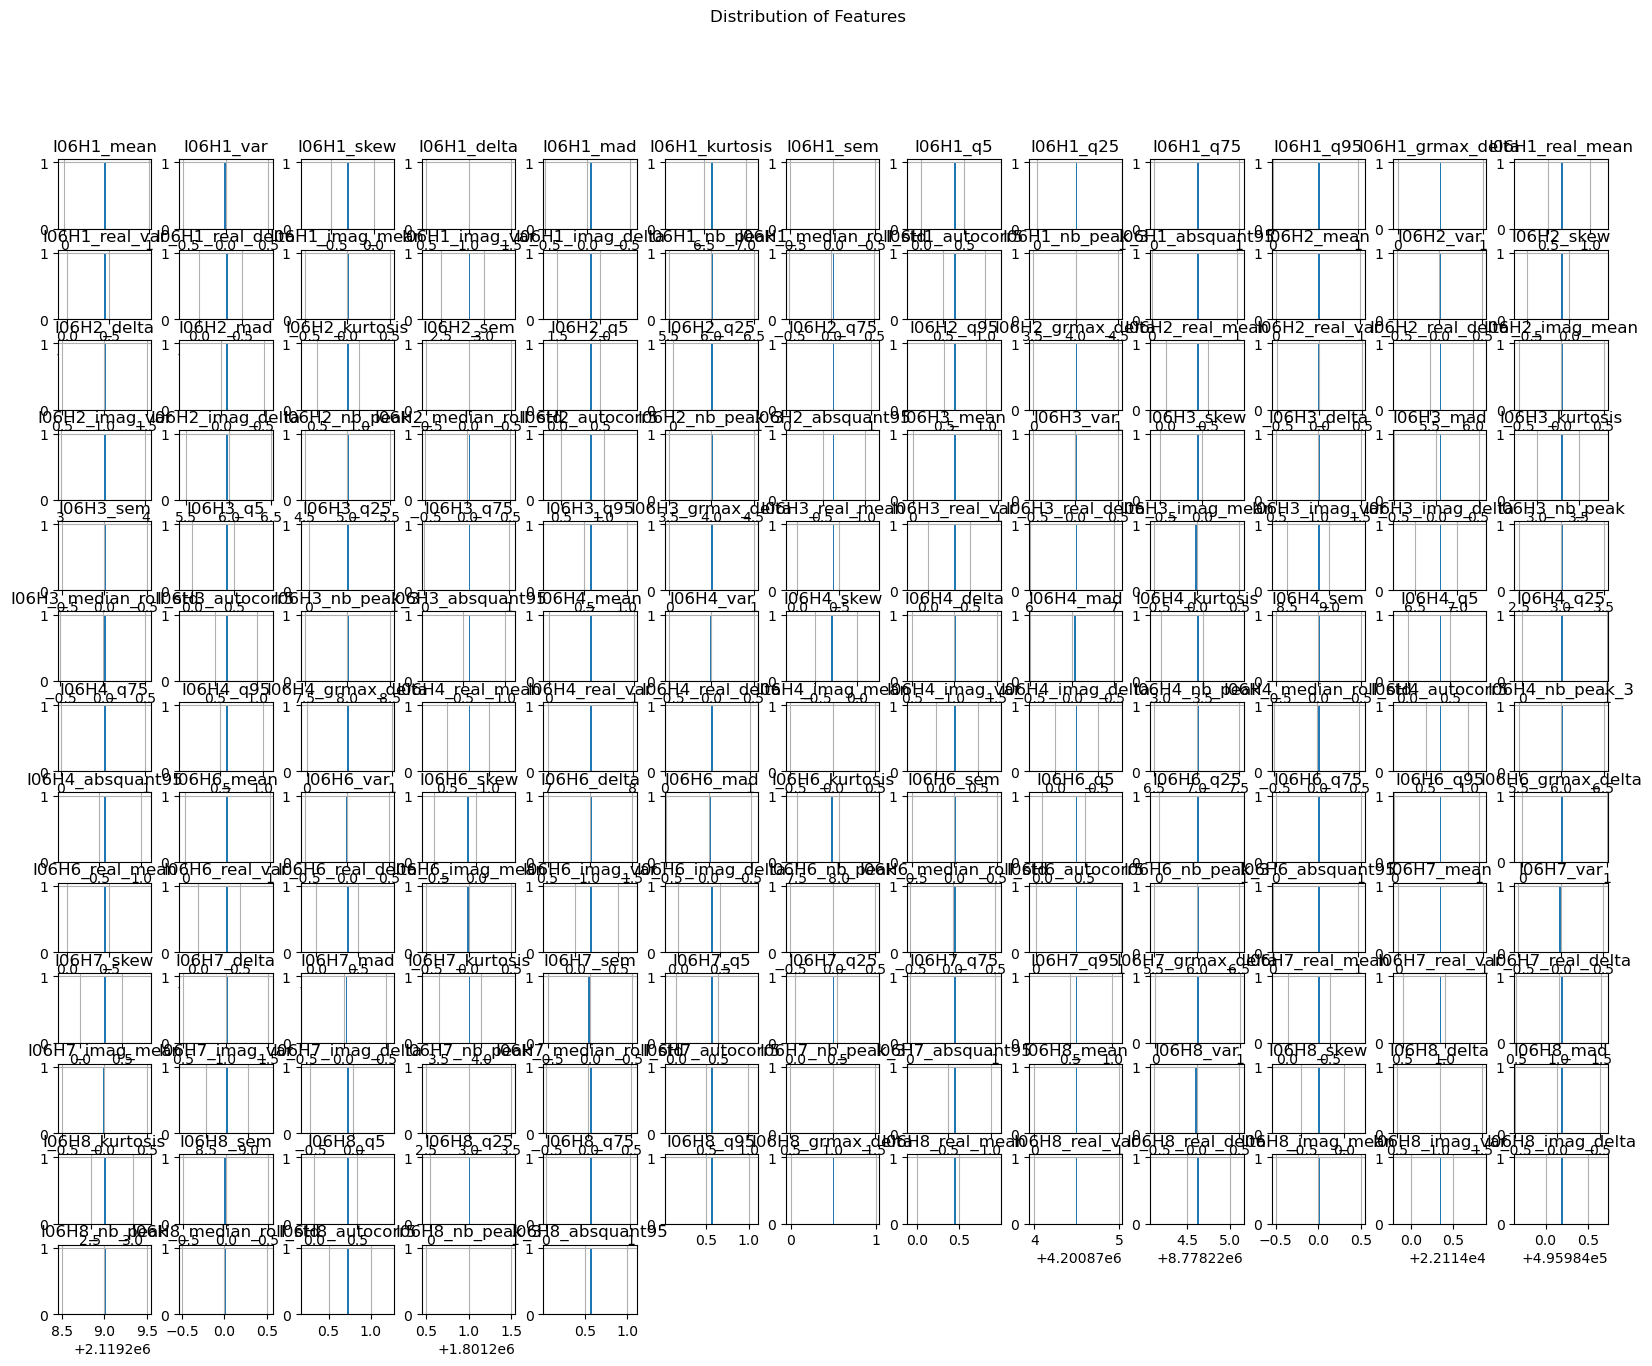

AttributeError: module 'matplotlib' has no attribute 'pyplot'

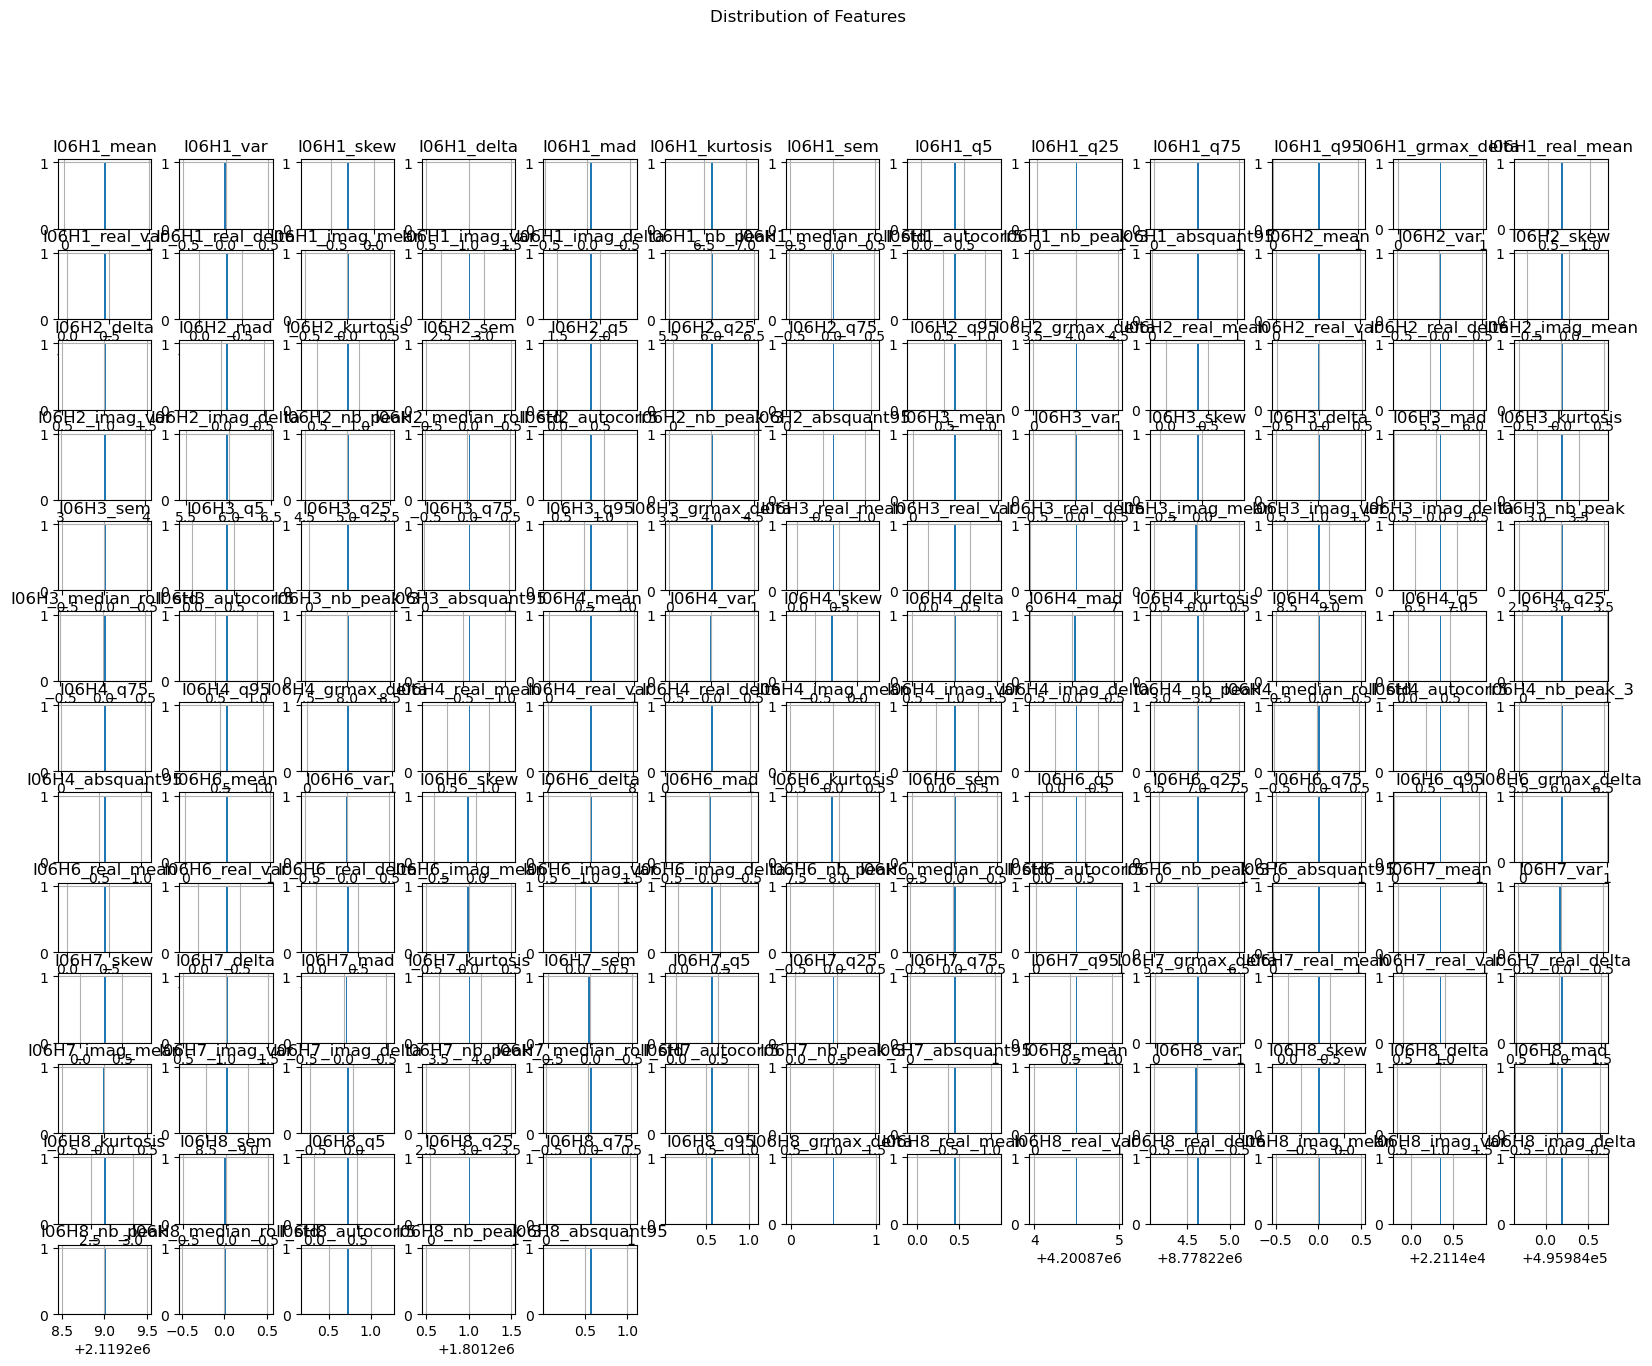

/usr/lib/python3.10/site-packages/numba/np/ufunc/ufuncbuilder.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  self.nb_func = jit(_target='npyufunc', cache=cache)(py_func)


AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [7]:
# Histograms for each feature
train_features.hist(bins=50, figsize=(20,15))
plt.suptitle("Distribution of Features")
plt.show()

In [ ]:
# Boxplot for each feature
plt.figure(figsize=(20, 8))
sns.boxplot(data=train_features)
plt.xticks(rotation=90)
plt.title("Boxplot of Features")
plt.show()

In [ ]:
# Correlation matrix
corr_matrix = train_features.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

#### Dimensionality Reduction

In [31]:
from sklearn.decomposition import PCA

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Adjust n_components as needed
train_reduced = pca.fit_transform(train_features)

print("Number of PCA components:", pca.n_components_)


Number of PCA components: 1


/usr/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [35]:
# Assuming the first column is the timestamp
train_numeric = train.drop(train.columns[0], axis=1)

n_clusters_options = [2, 3, 4, 5, 6]  # Example cluster options

# Use tqdm to display progress
for n_clusters in tqdm(n_clusters_options, desc="Fitting K-Means"):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(train_numeric)


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [36]:
# Example with a specific number of clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(train_numeric)

# Cluster assignments
cluster_labels = kmeans.labels_

# Add cluster labels to your DataFrame for analysis
train_numeric['cluster'] = cluster_labels


/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


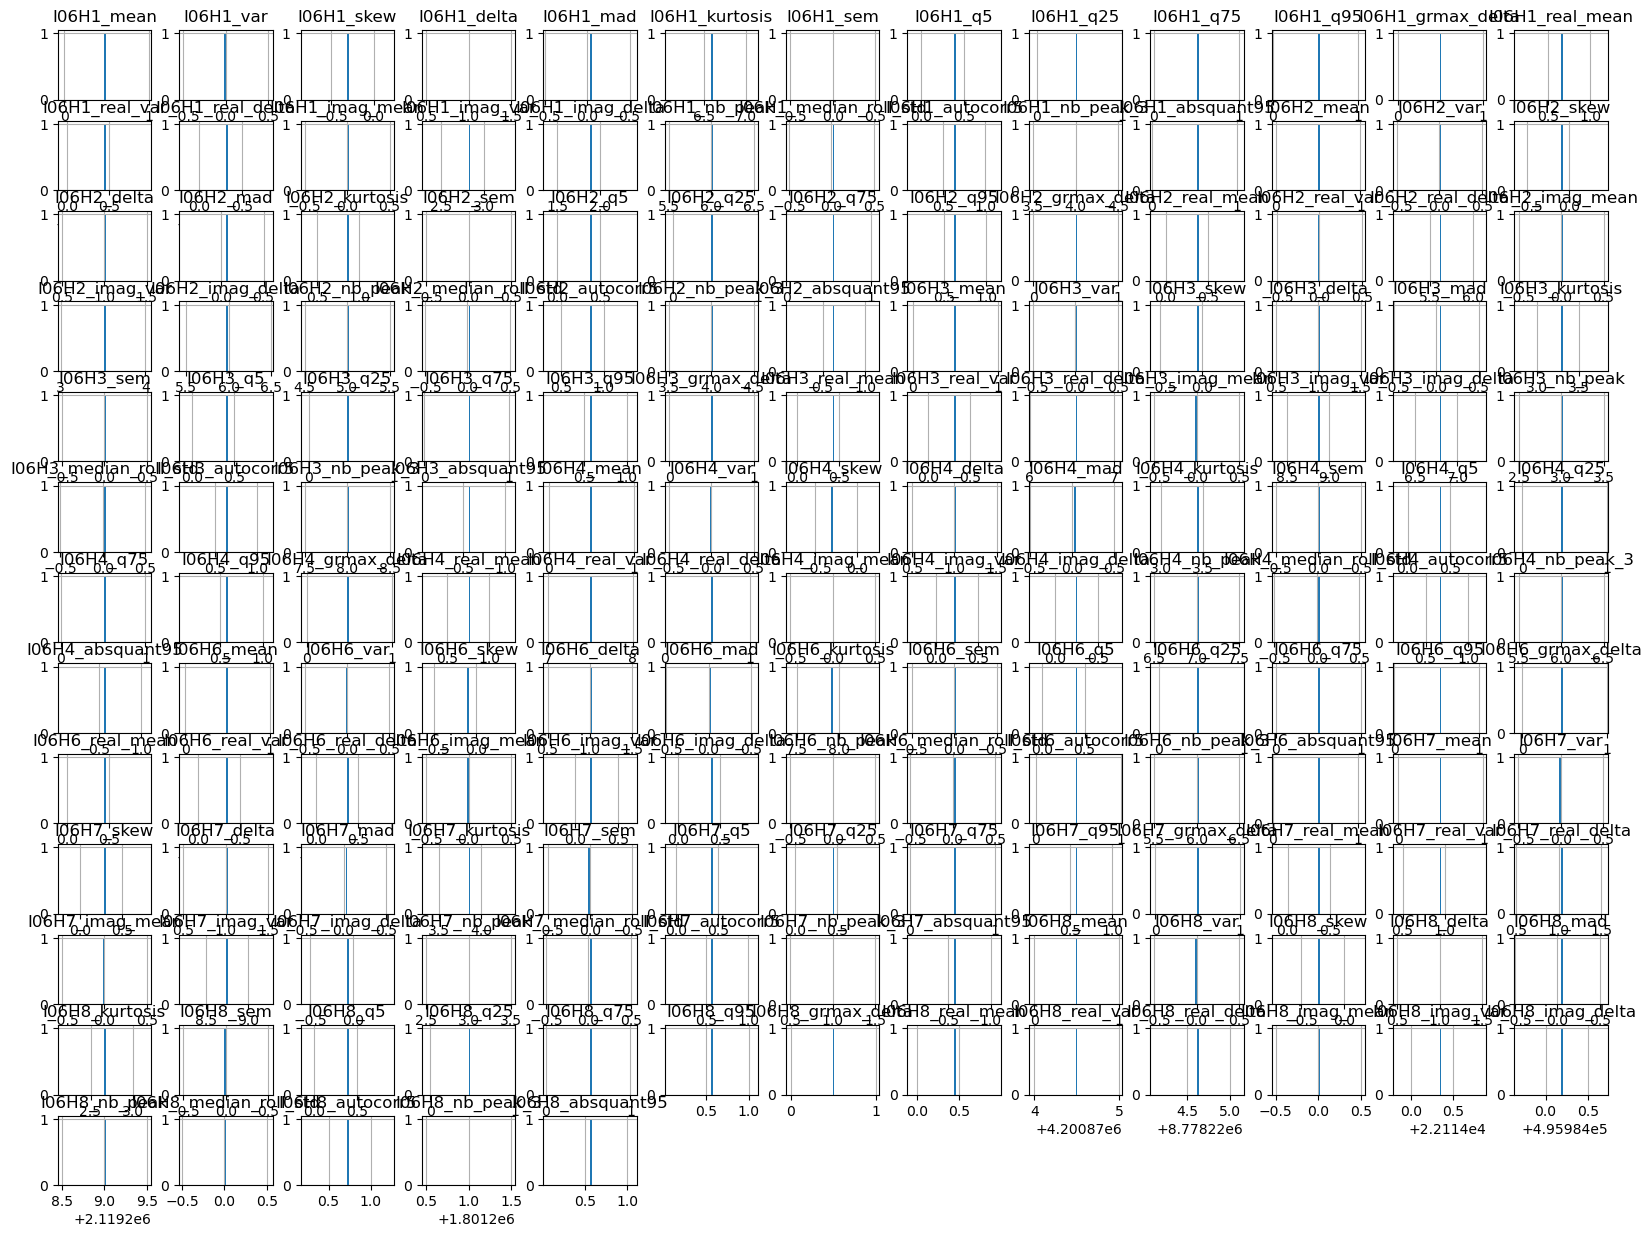

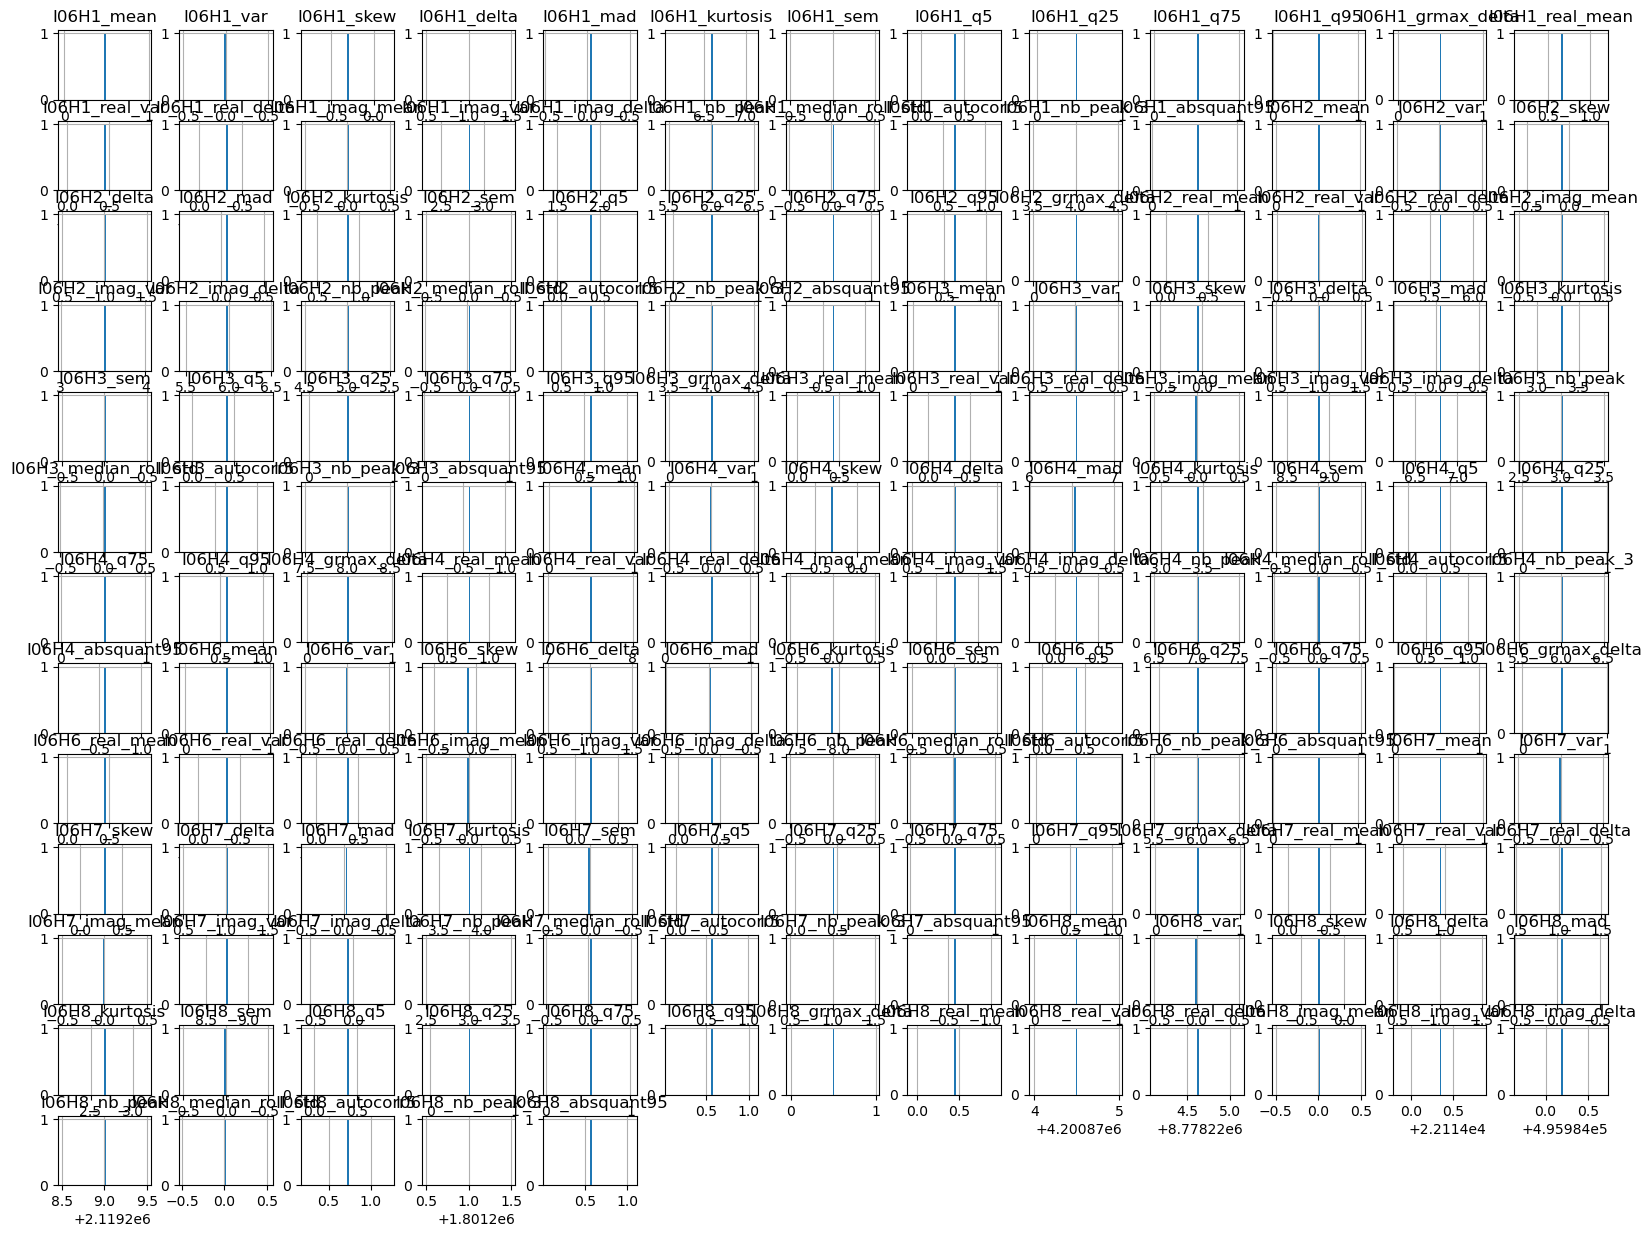

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_numeric.drop('cluster', axis=1))

# Scatter plot of the two PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=train_numeric['cluster'], palette='Set2')
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
# Centroids
centroids = kmeans.cluster_centers_

# If you reduced the dimensions for visualization, inverse transform the centroids
centroids_pca = pca.inverse_transform(centroids)

# Create a DataFrame for easier analysis
centroid_df = pd.DataFrame(centroids_pca, columns=train_numeric.columns[:-1])
print(centroid_df)
